In [3]:
import os
import json
import pandas as pd

# ========================
# 参数设置
# ========================
INPUT_FOLDER = "raw_data"        # 存放单个JSON文件的文件夹
OUTPUT_JSON = "merged_data.json" # 合并后的JSON输出
OUTPUT_CSV = "merged_data.csv"   # 合并后的CSV输出

# ========================
# 合并JSON：按文件名分组
# ========================
restructured_data = {}  # 最终结构：{ filename: { catalyst_name: data } }

for filename in os.listdir(INPUT_FOLDER):
    if filename.endswith(".json"):
        filepath = os.path.join(INPUT_FOLDER, filename)
        
        # 使用文件名（去掉 .json）作为 paper_name
        paper_name = os.path.splitext(filename)[0]  # 例如: "paper1.json" -> "paper1"
        
        with open(filepath, "r", encoding="utf-8") as f:
            try:
                data = json.load(f)
                
                # 确保 paper_name 有对应的字典
                if paper_name not in restructured_data:
                    restructured_data[paper_name] = {}
                
                # 如果 data 是列表（多条记录）
                if isinstance(data, list):
                    for item in data:
                        catalyst_name = item["Materials_Structure"].get("Catalyst_Name", "Unknown_Catalyst")
                        restructured_data[paper_name][catalyst_name] = item
                else:
                    # 如果是单个对象
                    catalyst_name = data["Materials_Structure"].get("Catalyst_Name", "Unknown_Catalyst")
                    restructured_data[paper_name][catalyst_name] = data
                    
            except json.JSONDecodeError as e:
                print(f"解析失败：{filename} -> {e}")
            except Exception as e:
                print(f"处理文件时出错：{filename} -> {e}")

# ========================
# 保存合并后的 JSON（按文件名 + 催化剂名分组）
# ========================
with open(OUTPUT_JSON, "w", encoding="utf-8") as f:
    json.dump(restructured_data, f, ensure_ascii=False, indent=2)

print(f"已成功合并 {sum(len(v) for v in restructured_data.values())} 条催化剂记录")
print(f"来自 {len(restructured_data)} 个文件，保存到 {OUTPUT_JSON}")

# ========================
# 转换为表格（展开嵌套字段，带文件名和催化剂名）
# ========================
flat_records = []
for paper_name, catalysts in restructured_data.items():
    for catalyst_name, data in catalysts.items():
        record = {
            "Paper_File": paper_name,           # 新增：文件名
            "Catalyst_Name": catalyst_name      # 新增：催化剂名称（冗余但方便查看）
        }
        # 合并所有字段
        record.update(data)
        flat_records.append(record)

df = pd.json_normalize(flat_records)
df.to_csv(OUTPUT_CSV, index=False, encoding="utf-8-sig")
print(f"已保存表格到 {OUTPUT_CSV}，共 {len(df)} 行")

处理文件时出错：10.1002_aenm.202000689_raw.json -> 'Materials_Structure'
处理文件时出错：10.1002_celc.201600163_raw.json -> 'Materials_Structure'
处理文件时出错：10.1002_celc.202000351_raw.json -> 'Materials_Structure'
处理文件时出错：10.1002_cssc.202300699_raw.json -> 'Materials_Structure'
处理文件时出错：10.1002_smll.202504253_raw.json -> 'Materials_Structure'
处理文件时出错：10.1016_j.carbon.2020.02.046_raw.json -> 'Materials_Structure'
处理文件时出错：10.1016_j.cej.2021.130241_raw.json -> 'Materials_Structure'
处理文件时出错：10.1016_j.electacta.2013.12.022_raw.json -> 'Materials_Structure'
处理文件时出错：10.1016_j.electacta.2024.144691_raw.json -> 'Materials_Structure'
处理文件时出错：10.1016_j.electacta.2024.145620_raw.json -> 'Materials_Structure'
处理文件时出错：10.1016_j.nanoen.2023.109154_raw.json -> 'Materials_Structure'
处理文件时出错：10.1021_acsaem.9b01181_raw.json -> 'Materials_Structure'
处理文件时出错：10.1021_acsami.1c15554_raw.json -> 'Materials_Structure'
处理文件时出错：10.1039_c2sc20657a_raw.json -> 'Materials_Structure'
处理文件时出错：10.1039_c8ta02325e_raw.json -> 'Materials_St

In [6]:
import pandas as pd
import numpy as np

# ========================
# 1. 读取数据
# ========================
CSV_FILE = "merged_data.csv"  # 请确保路径正确
df = pd.read_csv(CSV_FILE)

# ========================
# 2. 筛选目标列非 NA 的行
# ========================
target_col = "Electrochemical_Performance.E_half_V_vs_RHE"

# 转换为数值型，NA 变为 NaN
df[target_col] = pd.to_numeric(df[target_col], errors='coerce')

# 筛选非 NA 行
valid_df = df[df[target_col].notna()].copy()
print(f"目标列非 NA 的记录数: {len(valid_df)} / {len(df)}")

# ========================
# 3. 统计每列非空数量
# ========================
non_na_counts = valid_df.notna().sum().sort_values(ascending=False)

# 转为 DataFrame 并添加百分比
stats = pd.DataFrame({
    'Non_NA_Count': non_na_counts,
    'Percentage': (non_na_counts / len(valid_df) * 100).round(2)
}).reset_index()
stats.columns = ['Column_Name', 'Non_NA_Count', 'Percentage_%']

# ========================
# 4. 输出结果
# ========================
print("\n" + "="*80)
print("当 Electrochemical_Performance.E_half_V_vs_RHE 非 NA 时，各列非空数量统计（降序）")
print("="*80)
print(stats.to_string(index=False))



目标列非 NA 的记录数: 54 / 107

当 Electrochemical_Performance.E_half_V_vs_RHE 非 NA 时，各列非空数量统计（降序）
                                        Column_Name  Non_NA_Count  Percentage_%
                                         Paper_File            54        100.00
                 Materials_Structure.Multi_Metal_YN            54        100.00
           Experimental_Conditions.Electrolyte_Type            54        100.00
    Materials_Structure.Metal_Introduction_Strategy            54        100.00
        Electrochemical_Performance.E_half_V_vs_RHE            54        100.00
                                      Catalyst_Name            54        100.00
                   Materials_Structure.Active_Metal            54        100.00
                  Materials_Structure.Catalyst_Name            54        100.00
                                           Paper_ID            54        100.00
         Experimental_Conditions.Electrolyte_Conc_M            53         98.15
                       Materia

In [16]:
import pandas as pd

# 1. 读取原始数据
df = pd.read_csv("merged_data.csv")

# 2. 目标列
target_col = "Electrochemical_Performance.E_half_V_vs_RHE"

# 3. 转为数值，筛选非空
df_filtered = df[df[target_col].notna()].copy()

print(f"筛选后样本数: {len(df_filtered)} 条")

# 4. 14 个核心特征列名（原始）
core_features = [
    'Materials_Structure.Active_Metal',
    'Materials_Structure.MOF_Name',
    'Materials_Structure.Main_Form_SA_or_Cluster',
    'Materials_Structure.Pyrolysis_Temp_C',
    'Materials_Structure.Ligand_Type',
    'Materials_Structure.Pyrolysis_Atmosphere',
    'Materials_Structure.Active_Site_Type',
    'Materials_Structure.BET_m2g',
    'Experimental_Conditions.Rotation_rpm',
    'Experimental_Conditions.Scan_Rate_mV_s',
    'Experimental_Conditions.Electrolyte_Type',
    'Materials_Structure.Metal_Introduction_Strategy',
    'Electrochemical_Performance.Power_Density_W_cm2',
    'Experimental_Conditions.Cycle_Number',
]

# 5. 确保所有列存在
missing_cols = [col for col in core_features if col not in df_filtered.columns]
if missing_cols:
    print(f"警告：以下列缺失: {missing_cols}")
else:
    print("所有 14 个特征列均存在")

# 6. 提取最终数据集
final_cols = core_features + [target_col]
extracted_df = df_filtered[final_cols].reset_index(drop=True)

# 7. 保存为 CSV（原始值！）
output_file = "1.csv"
extracted_df.to_csv(output_file, index=False, encoding="utf-8-sig")

print(f"已保存: {output_file}")
print(f"共 {len(extracted_df)} 行，{len(extracted_df.columns)} 列")

筛选后样本数: 60 条
所有 14 个特征列均存在
已保存: 1.csv
共 60 行，15 列


建模样本数: 54 条

模型性能（预测 E_half_V_vs_RHE）:
  MAE: 0.0979 V  →  97.9 mV
  R² : 0.241
  5折 CV MAE: 0.1200 V  →  120.0 mV

特征重要性排名:
Active_Metal_Pt                                0.6009
Active_Metal_Fe                                0.1855
Active_Metal_Co                                0.0888
MOF_ZIF8                                       0.0570
MOF_Other                                      0.0346
Materials_Structure.Main_Form_SA_or_Cluster    0.0264
MOF_ZIF67                                      0.0069
dtype: float64


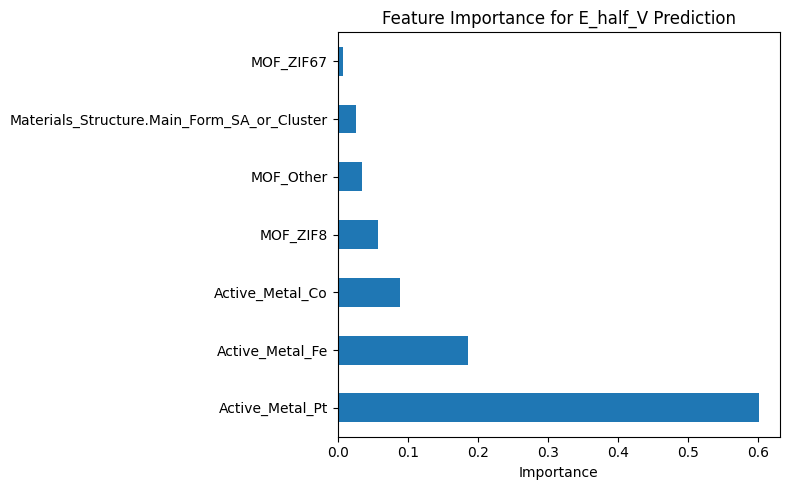


已保存预测结果：E_half_V_predicted_7_features.csv


In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# ========================
# 1. 加载数据（上一步保存的文件）
# ========================
df = pd.read_csv("raw_54_samples_14_features.csv")

# 目标列
target = "Electrochemical_Performance.E_half_V_vs_RHE"
df[target] = pd.to_numeric(df[target], errors='coerce')

# ========================
# 2. 特征选择（你指定的 7 个）
# ========================
features = [
    'Materials_Structure.Main_Form_SA_or_Cluster',
    'Active_Metal_Pt', 'Active_Metal_Fe', 'Active_Metal_Co',
    'MOF_ZIF8', 'MOF_ZIF67', 'MOF_Other'
]

X = df[features].copy()
y = df[target].dropna()

# 同步 X 和 y（去掉 target 为 NA 的行）
valid_idx = y.notna()
X = X.loc[valid_idx].reset_index(drop=True)
y = y[valid_idx].reset_index(drop=True)

print(f"建模样本数: {len(X)} 条")

# ========================
# 3. 预处理
# ========================
# 分类列编码
le = LabelEncoder()
X['Materials_Structure.Main_Form_SA_or_Cluster'] = le.fit_transform(
    X['Materials_Structure.Main_Form_SA_or_Cluster'].fillna("Unknown").astype(str)
)

# 数值列已是 0/1，无需处理

# ========================
# 4. 训练模型
# ========================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(
    n_estimators=500,
    max_depth=6,
    min_samples_leaf=1,
    random_state=42
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# ========================
# 5. 评估
# ========================
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\n模型性能（预测 E_half_V_vs_RHE）:")
print(f"  MAE: {mae:.4f} V  →  {mae*1000:.1f} mV")
print(f"  R² : {r2:.3f}")

# 5折交叉验证
cv_mae = -cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error').mean()
print(f"  5折 CV MAE: {cv_mae:.4f} V  →  {cv_mae*1000:.1f} mV")

# ========================
# 6. 特征重要性
# ========================
importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\n特征重要性排名:")
print(importances.round(4))

# 可视化
plt.figure(figsize=(8, 5))
importances.plot(kind='barh')
plt.title("Feature Importance for E_half_V Prediction")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

# ========================
# 7. 预测所有样本（包括 NA）
# ========================
X_full = df[features].copy()
X_full['Materials_Structure.Main_Form_SA_or_Cluster'] = le.transform(
    X_full['Materials_Structure.Main_Form_SA_or_Cluster'].fillna("Unknown").astype(str)
)
df['E_half_V_predicted'] = model.predict(X_full)

# 保存完整结果
df.to_csv("E_half_V_predicted_7_features.csv", index=False, encoding="utf-8-sig")
print(f"\n已保存预测结果：E_half_V_predicted_7_features.csv")

In [ ]:
def active_metal_similarity(metal_str1, metal_str2):
    """
    计算两个 Active_Metal 字符串的相似度 (0~1)
    规则：
    - 完全相同 → 1.0
    - 集合交集 / 并集（Jaccard 相似度）
    - 忽略顺序、空格、逗号
    """
    if pd.isna(metal_str1) or pd.isna(metal_str2):
        return 0.0  # 任一缺失 → 完全不相似
    
    # 转为集合
    set1 = set(re.split(r'[,\s]+', str(metal_str1).strip()))
    set2 = set(re.split(r'[,\s]+', str(metal_str2).strip()))
    
    # 去除空字符串
    set1 = {x for x in set1 if x}
    set2 = {x for x in set2 if x}
    
    if not set1 and not set2:
        return 1.0  # 两个都空
    if not set1 or not set2:
        return 0.0  # 一个空一个有
    
    # Jaccard 相似度
    intersection = len(set1 & set2)
    union = len(set1 | set2)
    return intersection / union



In [ ]:
import re
import pandas as pd

def extract_mof_keywords(text):
    """
    从 MOF 名称中提取“关键词集合”
    输入：字符串（如 "ZIF-67@ZIF-8"）
    输出：set，如 {'zif-8', 'zif-67'}
    """
    if pd.isna(text):
        return set()  # 空值 → 空集合
    
    text = str(text).strip().lower()
    keywords = set()

    # 1. 精确匹配 ZIF-8 / ZIF-67
    if 'zif-8' in text:
        keywords.add('zif-8')
    if 'zif-67' in text:
        keywords.add('zif-67')
    
    # 2. 泛 ZIF（但不与上面冲突）
    if 'zif' in text and 'zif-8' not in text and 'zif-67' not in text:
        keywords.add('zif')
    
    # 3. 其他知名 MOF
    known_mofs = [
        'mof-5', 'hkust-1', 'mil-101', 'nh2-mil-101', 'gt-18',
        'zn/fe-mof', 'fe-zif8', 'cozn-zif', 'zif-zn-co'
    ]
    for m in known_mofs:
        if m in text:
            keywords.add(m)
    
    # 4. 特殊结构词
    if 'bimetallic' in text:
        keywords.add('bimetallic')
    
    return keywords

def mof_name_similarity(mof1, mof2):
    """
    计算两个 MOF_Name 的相似度 (0~1)
    完全处理空值！
    """
    # --- 步骤 1：空值判断 ---
    if pd.isna(mof1) and pd.isna(mof2):
        return 1.0  # 两个都空 → 完全相似
    if pd.isna(mof1) or pd.isna(mof2):
        return 0.0  # 一个空一个有 → 完全不相似

    s1 = str(mof1).strip().lower()
    s2 = str(mof2).strip().lower()

    # --- 步骤 2：完全相同 ---
    if s1 == s2:
        return 1.0

    # --- 步骤 3：提取关键词 ---
    keywords1 = extract_mof_keywords(s1)
    keywords2 = extract_mof_keywords(s2)

    # --- 步骤 4：Jaccard 相似度 ---
    if not keywords1 or not keywords2:
        return 0.0
    intersection = len(keywords1 & keywords2)
    union = len(keywords1 | keywords2)
    jaccard = intersection / union

    # --- 步骤 5：奖励机制 ---
    bonus = 0.0
    if 'zif-8' in keywords1 and 'zif-8' in keywords2:
        bonus += 0.3
    if 'zif-67' in keywords1 and 'zif-67' in keywords2:
        bonus += 0.3
    if 'zif' in keywords1 and 'zif' in keywords2:
        bonus += 0.1

    # --- 步骤 6：最终得分（封顶 1.0）---
    return min(1.0, jaccard + bonus)

In [ ]:
def numeric_similarity(val1, val2, col_name, stats_dict):
    """
    计算两个数值的相似度 (0~1)
    空值规则：只要有缺失，相似度直接为 0.0
    """
    # --- 情况 1 & 2：任一缺失 → 相似度 = 0.0 ---
    if pd.isna(val1) or pd.isna(val2):
        return 0.0

    # --- 情况 3：两个都有值 ---
    mean, std = stats_dict[col_name]
    if std == 0:
        std = 1  # 防止除零

    z1 = (val1 - mean) / std
    z2 = (val2 - mean) / std

    distance = abs(z1 - z2)
    similarity = np.exp(-distance)  # 指数衰减

    return similarity

In [ ]:
def main_form_similarity(set1, set2):
    """
    输入：两个形态集合（如 {'sa'}, {'sa', 'cluster'}）
    输出：相似度 0~1
    """
    if not set1 or not set2:
        return 0.0
    
    intersection = len(set1 & set2)
    union = len(set1 | set2)
    jaccard = intersection / union
    
    # 奖励：SA 更重要
    if 'sa' in set1 and 'sa' in set2:
        jaccard = min(1.0, jaccard + 0.2)
    
    return jaccard

In [ ]:
import re
import pandas as pd

# ========================
# 1. 配体别名映射表（核心！）
# ========================
LIGAND_ALIASES = {
    '2-methylimidazole': '2-mi',
    'mim': '2-mi',
    '2-mim': '2-mi',
    '2-methylimidazolate': '2-mi',
    '2-mi': '2-mi',
    
    '1,4-benzenedicarboxylate': 'bdc',
    'bdc': 'bdc',
    'terephthalic acid': 'bdc',
    
    '1,3,5-trimesic acid (h3btc)': 'btc',
    'btc': 'btc',
    'h3btc': 'btc',
    
    '2-aminoterephthalic acid': 'nh2-bdc',
    'nh2-bdc': 'nh2-bdc',
    
    '6-chloropurine': '6-cp',
    '2-aminothiazole': '2-atz'
}

# ========================
# 2. 提取标准化配体集合
# ========================
def extract_ligand_set(ligand_str):
    """
    输入："2-methylimidazole, 6-chloropurine"
    输出：{'2-mi', '6-cp'}
    """
    if pd.isna(ligand_str):
        return set()
    
    s = str(ligand_str).lower().strip()
    if s in ['', 'nan', 'none']:
        return set()
    
    # 分割
    parts = re.split(r'[,\&\+]', s)
    ligands = set()
    
    for part in parts:
        part = part.strip()
        if not part:
            continue
        
        # 直接匹配别名
        normalized = LIGAND_ALIASES.get(part, None)
        if normalized:
            ligands.add(normalized)
            continue
        
        # 模糊匹配关键词
        if '2-methylimidazole' in part or 'mim' in part:
            ligands.add('2-mi')
        elif 'benzenedicarboxylate' in part or 'bdc' in part:
            ligands.add('bdc')
        elif 'trimesic' in part or 'btc' in part:
            ligands.add('btc')
        elif 'aminoterephthalic' in part:
            ligands.add('nh2-bdc')
        elif 'chloropurine' in part:
            ligands.add('6-cp')
        elif 'aminothiazole' in part:
            ligands.add('2-atz')
        else:
            ligands.add(part[:10])  # 未知配体截断
    
    return ligands

def ligand_similarity(lig1, lig2):
    """
    输入：两个配体字符串
    输出：相似度 0~1
    """
    # 空值处理（按你要求）
    if pd.isna(lig1) or pd.isna(lig2):
        return 0.0
    
    set1 = extract_ligand_set(lig1)
    set2 = extract_ligand_set(lig2)
    
    if not set1 or not set2:
        return 0.0
    
    intersection = len(set1 & set2)
    union = len(set1 | set2)
    jaccard = intersection / union
    
    # 奖励：2-mi 是主流
    if '2-mi' in set1 and '2-mi' in set2:
        jaccard = min(1.0, jaccard + 0.3)
    
    return jaccard

In [18]:
import pandas as pd
import numpy as np
import json
import re

# ========================
# 1. 加载已知数据库（107 条）
# ========================
df_known = pd.read_csv("merged_data.csv")  # 你的原始文件
target_col = "Electrochemical_Performance.E_half_V_vs_RHE"
df_known[target_col] = pd.to_numeric(df_known[target_col], errors='coerce')

# 只保留有 E_half_V 的作为“已知库”
known = df_known[df_known[target_col].notna()].copy().reset_index(drop=True)
print(f"已知样本库：{len(known)} 条")

# ========================
# 2. 预处理 + 统计量
# ========================
num_cols = [
    'Materials_Structure.Pyrolysis_Temp_C',
    'Materials_Structure.BET_m2g',
    'Experimental_Conditions.Rotation_rpm',
    'Experimental_Conditions.Scan_Rate_mV_s'
]
for col in num_cols:
    known[col] = pd.to_numeric(known[col], errors='coerce')

stats = {col: (known[col].mean(), known[col].std() or 1) for col in num_cols}

# ========================
# 3. 所有相似度函数（完整版）
# ========================

# --- 1. Active Metal ---
def active_metal_similarity(metal_str1, metal_str2):
    if pd.isna(metal_str1) or pd.isna(metal_str2):
        return 0.0
    set1 = set(re.split(r'[,\s]+', str(metal_str1).strip()))
    set2 = set(re.split(r'[,\s]+', str(metal_str2).strip()))
    set1 = {x for x in set1 if x}
    set2 = {x for x in set2 if x}
    if not set1 or not set2:
        return 0.0
    intersection = len(set1 & set2)
    union = len(set1 | set2)
    return intersection / union

# --- 2. MOF Name ---
def extract_mof_keywords(text):
    if pd.isna(text):
        return set()
    text = str(text).lower()
    keywords = set()
    if 'zif-8' in text: keywords.add('zif-8')
    if 'zif-67' in text: keywords.add('zif-67')
    if 'zif' in text and 'zif-8' not in text and 'zif-67' not in text: keywords.add('zif')
    for name in ['mof-5', 'hkust-1', 'mil-101', 'nh2-mil-101', 'gt-18', 'zn/fe-mof']:
        if name in text: keywords.add(name)
    if 'bimetallic' in text: keywords.add('bimetallic')
    if 'cozn' in text or 'zn-co' in text: keywords.add('cozn')
    return keywords

def mof_name_similarity(mof1, mof2):
    if pd.isna(mof1) or pd.isna(mof2):
        return 0.0
    s1 = str(mof1).lower()
    s2 = str(mof2).lower()
    if s1 == s2:
        return 1.0
    k1 = extract_mof_keywords(s1)
    k2 = extract_mof_keywords(s2)
    if not k1 or not k2:
        return 0.0
    jaccard = len(k1 & k2) / len(k1 | k2)
    bonus = 0.0
    if 'zif-8' in k1 and 'zif-8' in k2: bonus += 0.3
    if 'zif-67' in k1 and 'zif-67' in k2: bonus += 0.3
    return min(1.0, jaccard + bonus)

# --- 3. Main Form + 智能填补 ---
def infer_main_form(row):
    form = row['form']
    metal = str(row['metal']).lower()
    if pd.isna(form) or form in ['', 'nan']:
        if 'pt' in metal:
            return 'Cluster'
        else:
            return 'SA'
    return form

def extract_form_set(s):
    s = str(s).lower().replace("and", ",").replace("&", ",")
    parts = [p.strip() for p in re.split(r'[,\s]+', s) if p.strip()]
    forms = set()
    for p in parts:
        if p in ['sa', 'single-atom', 'single atom']: forms.add('sa')
        elif p in ['cluster', 'clusters']: forms.add('cluster')
        elif p in ['dual-atom', 'dual atom', 'dual']: forms.add('sa')
    return forms

def main_form_similarity(set1, set2):
    if not set1 or not set2:
        return 0.0
    jaccard = len(set1 & set2) / len(set1 | set2)
    if 'sa' in set1 and 'sa' in set2:
        jaccard = min(1.0, jaccard + 0.2)
    return jaccard

# --- 4. Ligand ---
LIGAND_ALIASES = {
    '2-methylimidazole': '2-mi', 'mim': '2-mi', '2-mim': '2-mi', '2-methylimidazolate': '2-mi',
    '1,4-benzenedicarboxylate': 'bdc', 'bdc': 'bdc',
    '1,3,5-trimesic acid (h3btc)': 'btc', 'btc': 'btc',
    '2-aminoterephthalic acid': 'nh2-bdc',
    '6-chloropurine': '6-cp', '2-aminothiazole': '2-atz'
}

def extract_ligand_set(s):
    if pd.isna(s):
        return set()
    s = str(s).lower()
    parts = re.split(r'[,\&\+]', s)
    ligands = set()
    for p in parts:
        p = p.strip()
        norm = LIGAND_ALIASES.get(p, None)
        if norm:
            ligands.add(norm)
            continue
        if '2-methylimidazole' in p or 'mim' in p: ligands.add('2-mi')
        elif 'benzenedicarboxylate' in p: ligands.add('bdc')
        elif 'trimesic' in p: ligands.add('btc')
        elif 'aminoterephthalic' in p: ligands.add('nh2-bdc')
        elif 'chloropurine' in p: ligands.add('6-cp')
        elif 'aminothiazole' in p: ligands.add('2-atz')
    return ligands

def ligand_similarity(l1, l2):
    if pd.isna(l1) or pd.isna(l2):
        return 0.0
    set1 = extract_ligand_set(l1)
    set2 = extract_ligand_set(l2)
    if not set1 or not set2:
        return 0.0
    jaccard = len(set1 & set2) / len(set1 | set2)
    if '2-mi' in set1 and '2-mi' in set2:
        jaccard = min(1.0, jaccard + 0.3)
    return jaccard

# --- 5. Atmosphere ---
def extract_atmosphere_features(s):
    if pd.isna(s):
        return {}
    s = str(s).lower().strip()
    features = {'base': None, 'additive': None, 'sequence': False, 'special': None}
    if 'then' in s or '/' in s:
        features['sequence'] = True
    gases = re.split(r'[,\&\+]', s.replace('then', ','))
    gases = [g.strip().split()[0] for g in gases if g.strip()]
    main = None
    for g in gases:
        if g in ['ar', 'n2']: main = g
        elif g in ['h2', 'nh3', 'co2']: features['additive'] = g
        elif 'h2' in g: features['additive'] = 'h2'
        elif 'nh3' in g: features['additive'] = 'nh3'
    features['base'] = main or 'unknown'
    if 'moist' in s: features['special'] = 'moist'
    if 'co2' in s: features['special'] = 'co2'
    return features

def atmosphere_similarity(a1, a2):
    if pd.isna(a1) or pd.isna(a2):
        return 0.0
    f1 = extract_atmosphere_features(a1)
    f2 = extract_atmosphere_features(a2)
    if not f1 or not f2:
        return 0.0
    score = 0.0
    if f1['base'] == f2['base']: score += 0.5
    if f1['additive'] == f2['additive']: score += 0.3
    if f1['sequence'] == f2['sequence']: score += 0.1
    if f1['special'] == f2['special']: score += 0.1
    return score

# --- 6. Numeric ---
def numeric_similarity(v1, v2, col, stats):
    if pd.isna(v1) or pd.isna(v2):
        return 0.0
    mean, std = stats[col]
    z1 = (v1 - mean) / std
    z2 = (v2 - mean) / std
    return np.exp(-abs(z1 - z2))

# ========================
# 4. 权重
# ========================
WEIGHTS = {
    'metal': 1.5, 'mof': 1.2, 'form': 1.0, 'ligand': 0.8, 'atm': 0.7,
    'pyro_temp': 2.0, 'bet': 1.5, 'rpm': 0.8, 'scan_rate': 0.5
}

# ========================
# 5. 引擎类
# ========================
class SimilarityEngine:
    def __init__(self, known_df, stats, weights):
        self.known = known_df
        self.stats = stats
        self.w = weights

    def total_distance(self, new_row):
        dists = []
        for idx, ref in self.known.iterrows():
            d = 0.0
            d += self.w['metal'] * (1 - active_metal_similarity(new_row['metal'], ref['Materials_Structure.Active_Metal']))
            d += self.w['mof'] * (1 - mof_name_similarity(new_row['mof'], ref['Materials_Structure.MOF_Name']))
            form1 = infer_main_form(new_row)
            form2 = infer_main_form({'form': ref['Materials_Structure.Main_Form_SA_or_Cluster'], 'metal': ref['Materials_Structure.Active_Metal']})
            d += self.w['form'] * (1 - main_form_similarity(extract_form_set(form1), extract_form_set(form2)))
            d += self.w['ligand'] * (1 - ligand_similarity(new_row['ligand'], ref['Materials_Structure.Ligand_Type']))
            d += self.w['atm'] * (1 - atmosphere_similarity(new_row['atm'], ref['Materials_Structure.Pyrolysis_Atmosphere']))
            for col, key in zip(num_cols, ['pyro_temp', 'bet', 'rpm', 'scan_rate']):
                sim = numeric_similarity(new_row[col], ref[col], col, self.stats)
                d += self.w[key] * (1 - sim)
            dists.append((d, ref[target_col], idx))
        return dists

    def predict(self, new_row, k=3):
        dists = self.total_distance(new_row)
        dists.sort(key=lambda x: x[0])
        top_k = dists[:k]
        if not top_k:
            return np.nan, []
        weights = [1 / (d + 1e-8) for d, _, _ in top_k]
        pred = sum(w * val for w, (d, val, _) in zip(weights, top_k)) / sum(weights)
        neighbors = [(idx, known.iloc[idx], d, val) for d, val, idx in top_k]
        return pred, neighbors

engine = SimilarityEngine(known, stats, WEIGHTS)

# ========================
# 6. 预测函数（修复缩进！）
# ========================
def predict_e_half(new_sample_json):
    sample = {
        'metal': new_sample_json.get('Materials_Structure.Active_Metal'),
        'mof': new_sample_json.get('Materials_Structure.MOF_Name'),
        'form': new_sample_json.get('Materials_Structure.Main_Form_SA_or_Cluster'),
        'ligand': new_sample_json.get('Materials_Structure.Ligand_Type'),
        'atm': new_sample_json.get('Materials_Structure.Pyrolysis_Atmosphere'),
        'Materials_Structure.Pyrolysis_Temp_C': new_sample_json.get('Materials_Structure.Pyrolysis_Temp_C'),
        'Materials_Structure.BET_m2g': new_sample_json.get('Materials_Structure.BET_m2g'),
        'Experimental_Conditions.Rotation_rpm': new_sample_json.get('Experimental_Conditions.Rotation_rpm'),
        'Experimental_Conditions.Scan_Rate_mV_s': new_sample_json.get('Experimental_Conditions.Scan_Rate_mV_s'),
    }
    
    pred, neighbors = engine.predict(sample, k=3)
    
    return {
        "E_half_V_vs_RHE_predicted": round(pred, 4) if not np.isnan(pred) else None,
        "Top3_Similar_Samples": [
            {
                "Database_Index": idx,
                "E_half_V": round(val, 4),
                "Distance": round(d, 3),
                "Sample": {
                    "Active_Metal": known.iloc[idx]['Materials_Structure.Active_Metal'],
                    "MOF_Name": known.iloc[idx]['Materials_Structure.MOF_Name'],
                    "Main_Form": infer_main_form({'form': known.iloc[idx]['Materials_Structure.Main_Form_SA_or_Cluster'], 'metal': known.iloc[idx]['Materials_Structure.Active_Metal']})
                }
            }
            for idx, _, d, val in neighbors
        ]
    }

# ========================
# 7. 示例调用
# ========================
new_sample = {
    "Materials_Structure.Active_Metal": "Fe",
    "Materials_Structure.MOF_Name": "ZIF-8",
    "Materials_Structure.Main_Form_SA_or_Cluster": None,
    "Materials_Structure.Ligand_Type": "mIM",
    "Materials_Structure.Pyrolysis_Atmosphere": "N2",
    "Materials_Structure.Pyrolysis_Temp_C": 950,
    "Materials_Structure.BET_m2g": 1100,
    "Experimental_Conditions.Rotation_rpm": 1600,
    "Experimental_Conditions.Scan_Rate_mV_s": 10
}

result = predict_e_half(new_sample)
print(json.dumps(result, indent=2, ensure_ascii=False))

已知样本库：54 条
{
  "E_half_V_vs_RHE_predicted": 0.7924,
  "Top3_Similar_Samples": [
    {
      "Database_Index": 21,
      "E_half_V": 0.78,
      "Distance": 0.481,
      "Sample": {
        "Active_Metal": "Fe",
        "MOF_Name": "ZIF-8",
        "Main_Form": "SA"
      }
    },
    {
      "Database_Index": 17,
      "E_half_V": 0.803,
      "Distance": 0.511,
      "Sample": {
        "Active_Metal": "Fe",
        "MOF_Name": "ZIF-8",
        "Main_Form": "SA"
      }
    },
    {
      "Database_Index": 8,
      "E_half_V": 0.8,
      "Distance": 1.491,
      "Sample": {
        "Active_Metal": "Fe",
        "MOF_Name": "ZIF-8",
        "Main_Form": "SA"
      }
    }
  ]
}
